# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Example grids

In [2]:
easy_grid = np.loadtxt("../../data/robot_grids/easy_grid.csv", delimiter=",", dtype=int)
# medium_grid = np.loadtxt("../../data/robot_grids/medium_grid.csv", delimiter=",", dtype=str)
# hard_grid = np.loadtxt("../../data/robot_grids/hard_grid.csv", delimiter=",", dtype=str)

## Game rule constants

In [3]:
start_field, empty_field, obstacle_field, target_field = 0, 1, 2, 3
max_velocity = 2

# Plotting functions

In [4]:
def plot_state(grid_state, cmap=ListedColormap(["blue", "grey", "black", "green"]), field_lables=["Start", "Empty", "Obstacle", "Target"]):
    
    plt.imshow(grid_state, cmap=cmap)
    
    legend_handles = [plt.Rectangle((0, 0), 1, 1, fc=cmap.colors[i]) for i in range(len(field_lables))]
    plt.legend(legend_handles, field_lables, loc="upper left", bbox_to_anchor=(1, 1))
        
    plt.show()

# Game initialization

## Learning parameters

In [5]:
game_grid = easy_grid
start = (7,6)
n_episodes = 1000
gamma = 0.9

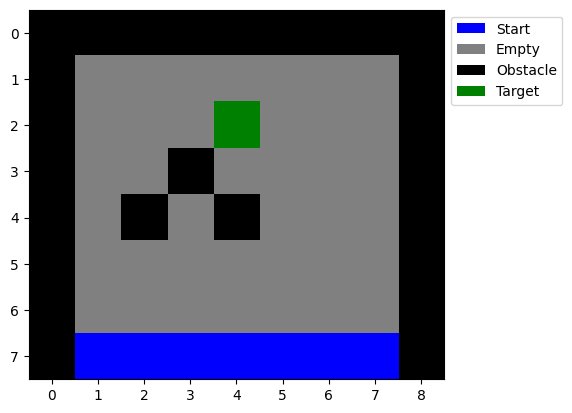

In [6]:
plot_state(game_grid)

## Agent initialization

In [7]:
target = tuple(np.argwhere(game_grid == target_field)[0])

actions = [(i, j) for i in range(-max_velocity, max_velocity + 1) for j in range(-max_velocity, max_velocity + 1) if (i, j) != (0, 0)]

states = [(i, j) for i in range(len(game_grid)) for j in range(len(game_grid[0])) if game_grid[i, j] != obstacle_field]
policy = {state: actions[np.random.randint(len(actions))] for state in states}

state_values = {state: 0 for state in states}
state_visits = {state: 0 for state in states}

# Episode generation function

In [8]:
def generate_episode(grid, actions, policy):
    episode = []

    options = np.argwhere(grid == start_field)
    state = tuple(options[np.random.randint(options.shape[0])])
    
    while grid[state] != target_field:
        action = actions[np.random.randint(len(actions))]
        next_state = tuple(np.add(state, action))

        if 0 <= next_state[0] < len(grid) and 0 <= next_state[1] < len(grid[0]) and grid[next_state] != obstacle_field:
            episode.append((state, action))
            state = next_state
        else:
            state = tuple(options[np.random.randint(options.shape[0])])

    return episode

# Training

In [9]:
for episode in range(n_episodes):
    episode = generate_episode(game_grid, actions, policy)    
    total_return = 0
    for state, action in reversed(episode):
        total_return = gamma * total_return -1
        state_values[state] += total_return
        state_visits[state] += 1
    
    for state in state_values.keys():
        if state not in [start, target]:
            possible_actions = [a for a in actions if tuple(np.add(state, a)) in states and game_grid[tuple(np.add(state, a))] != obstacle_field]
            
            if possible_actions:
                best_action = max(possible_actions, key=lambda a: state_values.get(tuple(np.add(state, a)), 0))
                policy[state] = best_action
        

# Visualization of the policy

In [10]:
def determine_direction_arrows(x, y):
    ups = max(0, -x)
    downs = max(0, x)
    lefts = max(0, -y)
    rights = max(0, y)
    
    arrows = ""
    
    for _ in range(ups):
        arrows = arrows + "↑"
        
    for _ in range(downs):
        arrows = arrows + "↓"
    
    for _ in range(lefts):
        arrows = arrows + "←"
        
    for _ in range(rights):
        arrows = arrows + "→"
    
    return arrows

In [11]:
for i in range(len(game_grid)):
    for j in range(len(game_grid[0])):
        if target[0] == i and target[1] == j:
            print("T", end="\t")
        elif game_grid[i,j] == 2:
            print("#", end="\t")
        else:
            print(determine_direction_arrows(*policy[i,j]), end="\t")
    print()

#	#	#	#	#	#	#	#	#	
#	↓	↓→→	↓→	↓	↓←	↓←←	←	#	
#	↑	→→	→	T	←	←←	↑	#	
#	↑↑	↑→→	#	↑	↑←	↑←←	↑↑	#	
#	↑↑	#	↑↑→	#	↑↑←	↑↑←←	↑↑	#	
#	↑↑	↑↑←	↑↑←←	↑↑←←	↑↑→→	↑↑→	↑↑	#	
#	↑↑	↑↑←	↑↑←←	↑↑→→	↑↑→→	↑↑→	↑↑	#	
#	↑	↑←	↑←←	↑←←	↑→→	↑↑←	↑	#	
